# Taxi Demand-Supply Gap Prediction #

## Load Packages ##

In [101]:
import pandas as pd
import numpy as np
import gc

from datetime import datetime, timedelta  

import sklearn
import seaborn as sns
# import matplotlib.image as image
import matplotlib.pylab as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

## Import Processed Data ##

In [2]:
data_dir = "/home/lee/Documents/DatasetsForGitHub/Taxi_Trajectory_Prediction/"
df_train = pd.read_pickle(data_dir+"train.pkl")
df_test = pd.read_pickle(data_dir+"test.pkl")

In [10]:
# create X, Y for model input
X_train = df_train.drop(['gap_forecast'], axis = 1)
y_train = df_train['gap_forecast']

X_test = df_test.drop(['gap_forecast'], axis = 1)
y_test = df_test['gap_forecast']

## Train Model ##

After comparing the performances, we choose to not one-hot encode the week, day of week, hour, and time window features. However, we still need to keep in mind that these features are categorical. 

In [33]:
# X = np.vstack([X_train, X_test])
# y = np.vstack([y_train, y_test])

Hyperparameter tuning:

In [ ]:
param_grid = {'max_bin': [20, 50], 
             'learning_rate': [0.01, 0.05, 0.1],
             'num_leaves': [32, 64]}

gsearch = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                       param_grid=param_grid, 
                       cv=5, scoring='neg_mean_absolute_error') 

lgb_model = gsearch.fit(X_train, y_train)

In [37]:
print('Hyperparameters selected by cross-validation: ', lgb_model.best_params_)
# lgb_model.best_score_

Hyperparameters selected by cross-validation:  {'learning_rate': 0.1, 'max_bin': 50, 'num_leaves': 64}


In [44]:
reg_lgb = lgb.LGBMRegressor(learning_rate=lgb_model.best_params_['learning_rate'], 
                            max_bin=lgb_model.best_params_['max_bin'], 
                            num_leaves=lgb_model.best_params_['num_leaves'], 
                            random_state=0)
reg_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_bin=50, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=64, objective=None, random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

Performance:

In [48]:
print('MAE in training set: {}'.format(mean_absolute_error(y_train, reg_lgb.predict(X_train))))
print('MAE in test set: {}'.format(mean_absolute_error(y_test, reg_lgb.predict(X_test))))

MAE in training set: 0.21295838974467302
MAE in test set: 0.19307741554963068


## Predict the Gap ##

Merge predictions to the hold-out test set. 

In [60]:
results = pd.concat([df_test.reset_index(), pd.DataFrame(reg_lgb.predict(X_test), columns=['gap_forecast_pred'])], axis=1)
# results['actual_prediction'] = results['gap_forecast'] - results['gap_forecast_pred']

results.set_index('index', inplace=True)

results['frame'] = results['week'].astype(str) + "-" + results['dayofweek'].astype(str) + "-" \
                    + results['time_window'].astype(str)

Format time windows to be user friendly. 

In [61]:
g = results.drop(['week', 'dayofweek', 'time_window'], axis=1)

le = LabelEncoder()
g['frame_le'] = le.fit_transform(g['frame'])

Sample heatmap of the gap for one time window:

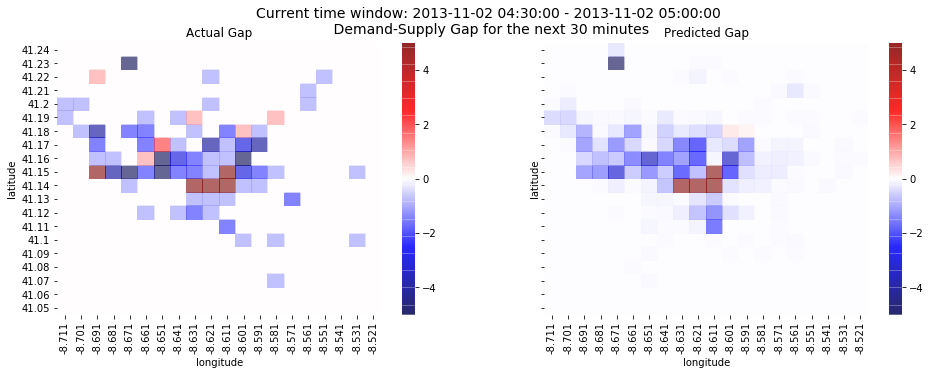

In [109]:
t = 72

time_window = 30

lat_min, lat_max = 41.04961, 41.24961
lon_min, lon_max = -8.71099, -8.51099

# inverse-transform the time window to the starting date and time
we, da, tw = np.asscalar(le.inverse_transform([t])).split('-')

start_t = datetime.strptime('2013' + '-' + str(int(float(we))) + '-' + str(int(float(da))) + '-'
                      + str(int(float(tw) * time_window / 60)) + '-' 
                      + str(int(float(tw) * time_window % 60)), "%Y-%W-%w-%H-%M")

r = g[g['frame_le'] == t]

real_forecast = r.groupby(by=['lon_localized', 'lat_localized'], as_index=False)['gap_forecast'].sum()
pred = r.groupby(by=['lon_localized', 'lat_localized'], as_index=False)['gap_forecast_pred'].sum()
# delta = r.groupby(by=['lon_localized', 'lat_localized'], as_index=False)['actual_prediction'].sum()

#     im = image.imread('porto.png')
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,5))
ax1.set_title("Actual Gap")
ax2.set_title("Predicted Gap")

fig.suptitle('Current time window: {} - {}\n Demand-Supply Gap for the next {} minutes'\
             .format(start_t, start_t+timedelta(minutes=time_window), time_window), fontsize=14)

real_forecast = real_forecast.pivot('lat_localized', 'lon_localized', 'gap_forecast')
pred = pred.pivot('lat_localized', 'lon_localized', 'gap_forecast_pred')
# deltaS = delta.pivot('lat_localized', 'lon_localized', 'actual_prediction')

f1 = sns.heatmap(real_forecast, ax=ax1, vmin=-5, vmax=5, cmap='seismic', alpha=0.6)
f2 = sns.heatmap(pred, ax=ax2, vmin=-5, vmax=5, cmap='seismic', alpha=0.6)
f1.set_xticklabels(np.around(np.arange(lon_min, lon_max, 0.01), 3))
f2.set_xticklabels(np.around(np.arange(lon_min, lon_max, 0.01), 3))
f1.set_yticklabels(np.around(np.arange(lat_min, lat_max, 0.01), 3))
f1.set_yticklabels(np.around(np.arange(lat_min, lat_max, 0.01), 3))
f1.set(xlabel='longitude', ylabel='latitude')
f2.set(xlabel='longitude', ylabel='latitude')
f2.invert_yaxis()

plt.show()

In this sample, our approach successfully predicts the areas with the highest demand-supply gaps (darkest red). The predicted heatmap also displays the areas with excess taxi supply. 

In [ ]:
# # define the model
# def larger_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(32, input_dim=19, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(8, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model


# # fix random seed for reproducibility
# seed = 0
# np.random.seed(seed)

# epochs = 32
# batch_size = 5
    
# # evaluate model with standardized dataset
# estimator = KerasRegressor(build_fn=larger_model, epochs=epochs, batch_size=batch_size, verbose=1)

# kfold = KFold(n_splits=5, random_state=seed)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)